# **Introducción**

Se realizará un análisis de series de tiempo utilizando datos históricos del índice FTSE 100, obtenidos a través de Yahoo Finance. El objetivo es modelar y predecir el comportamiento del índice utilizando modelos ARIMA. Se explorarán diferentes horizontes de predicción (7, 14, 21 y 28 días) utilizando tanto técnicas de rolling window como sin ella. Además, se evaluará la precisión de los modelos mediante métricas como MAPE, MAE, RMSE, MSE y R2. Finalmente, se compararán los modelos utilizando diferentes criterios de selección, como AIC, BIC y HQIC.

# **Importación de librerías necesarias**

In [81]:
import yfinance as yf
import pandas as pd
from IPython.display import display
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import missingno as msno
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from scipy.stats import jarque_bera
from scipy.stats import shapiro
import statsmodels.api as sm
import statsmodels.tsa.api as smtsa
from scipy.stats import kstest
import requests
import io
from statsmodels.tsa import stattools
from statsmodels.tsa import seasonal
warnings.simplefilter(action="ignore", category=FutureWarning)
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import mean_squared_error

import warnings
warnings.filterwarnings('ignore')

# **Importación y Exploración de la Base de Datos**

In [82]:
ftse100 = yf.download('^FTSE', start='2020-01-01', end='2024-09-01')  
display(ftse100.head(10))
display(ftse100.describe())

[*********************100%***********************]  1 of 1 completed


,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2020-01-02,7542.399902,7624.799805,7542.399902,7604.299805,7604.299805,482206700
2020-01-03,7604.299805,7626.399902,7551.000000,7622.399902,7622.399902,475628900
2020-01-06,7622.399902,7622.399902,7528.100098,7575.299805,7575.299805,516783400
2020-01-07,7575.299805,7604.600098,7562.100098,7573.899902,7573.899902,511576100
2020-01-08,7573.899902,7579.500000,7525.000000,7574.899902,7574.899902,606225000
2020-01-09,7574.899902,7627.799805,7574.899902,7598.100098,7598.100098,653838100
2020-01-10,7598.100098,7632.000000,7585.100098,7587.899902,7587.899902,651315600
2020-01-13,7587.899902,7635.799805,7582.500000,7617.600098,7617.600098,659019400
2020-01-14,7617.600098,7650.700195,7588.799805,7622.399902,7622.399902,697648200


,Open,High,Low,Close,Adj Close,Volume
count,1176.000000,1176.000000,1176.000000,1176.000000,1176.000000,1.176000e+03
mean,7194.922710,7240.158602,7149.661824,7195.627982,7195.627982,8.503840e+08
std,665.765681,655.291936,678.511316,666.677821,666.677821,3.244453e+08
min,4993.899902,5181.000000,4898.799805,4993.899902,4993.899902,0.000000e+00
25%,6919.100098,6962.625122,6858.975098,6919.100098,6919.100098,6.479182e+08
50%,7355.750000,7405.199951,7318.250000,7355.750000,7355.750000,7.830432e+08
75%,7608.125122,7642.200195,7567.575073,7608.375122,7608.375122,9.768749e+08
max,8445.799805,8474.400391,8427.900391,8445.799805,8445.799805,2.813498e+09


## **Descripción de Variables**

| Variable   | Descripción                                                                                   |
|------------|-----------------------------------------------------------------------------------------------|
| Date       | Fecha de la observación                                                    |
| Open       | Precio de apertura del índice FTSE 100 en la fecha especificada                             |
| High       | Precio más alto alcanzado por el índice FTSE 100 durante la jornada de trading en esa fecha  |
| Low        | Precio más bajo alcanzado por el índice FTSE 100 durante la jornada de trading en esa fecha  |
| Close      | Precio de cierre del índice FTSE 100 en la fecha especificada                           |
| Adj Close  | Precio de cierre ajustado del índice FTSE 100, considerando dividendos, splits, y otros ajustes|
| Volume     | Volumen de acciones negociadas para el índice FTSE 100 en la fecha especificada         |

# **Visualización de Variables del Índice FTSE 100**

En esta sección, se presentan gráficos de líneas para cada una de las variables del conjunto de datos del índice FTSE 100. Estas visualizaciones permiten observar el comportamiento de cada variable a lo largo del tiempo, proporcionando una visión clara de las tendencias, volatilidad y patrones del mercado. 

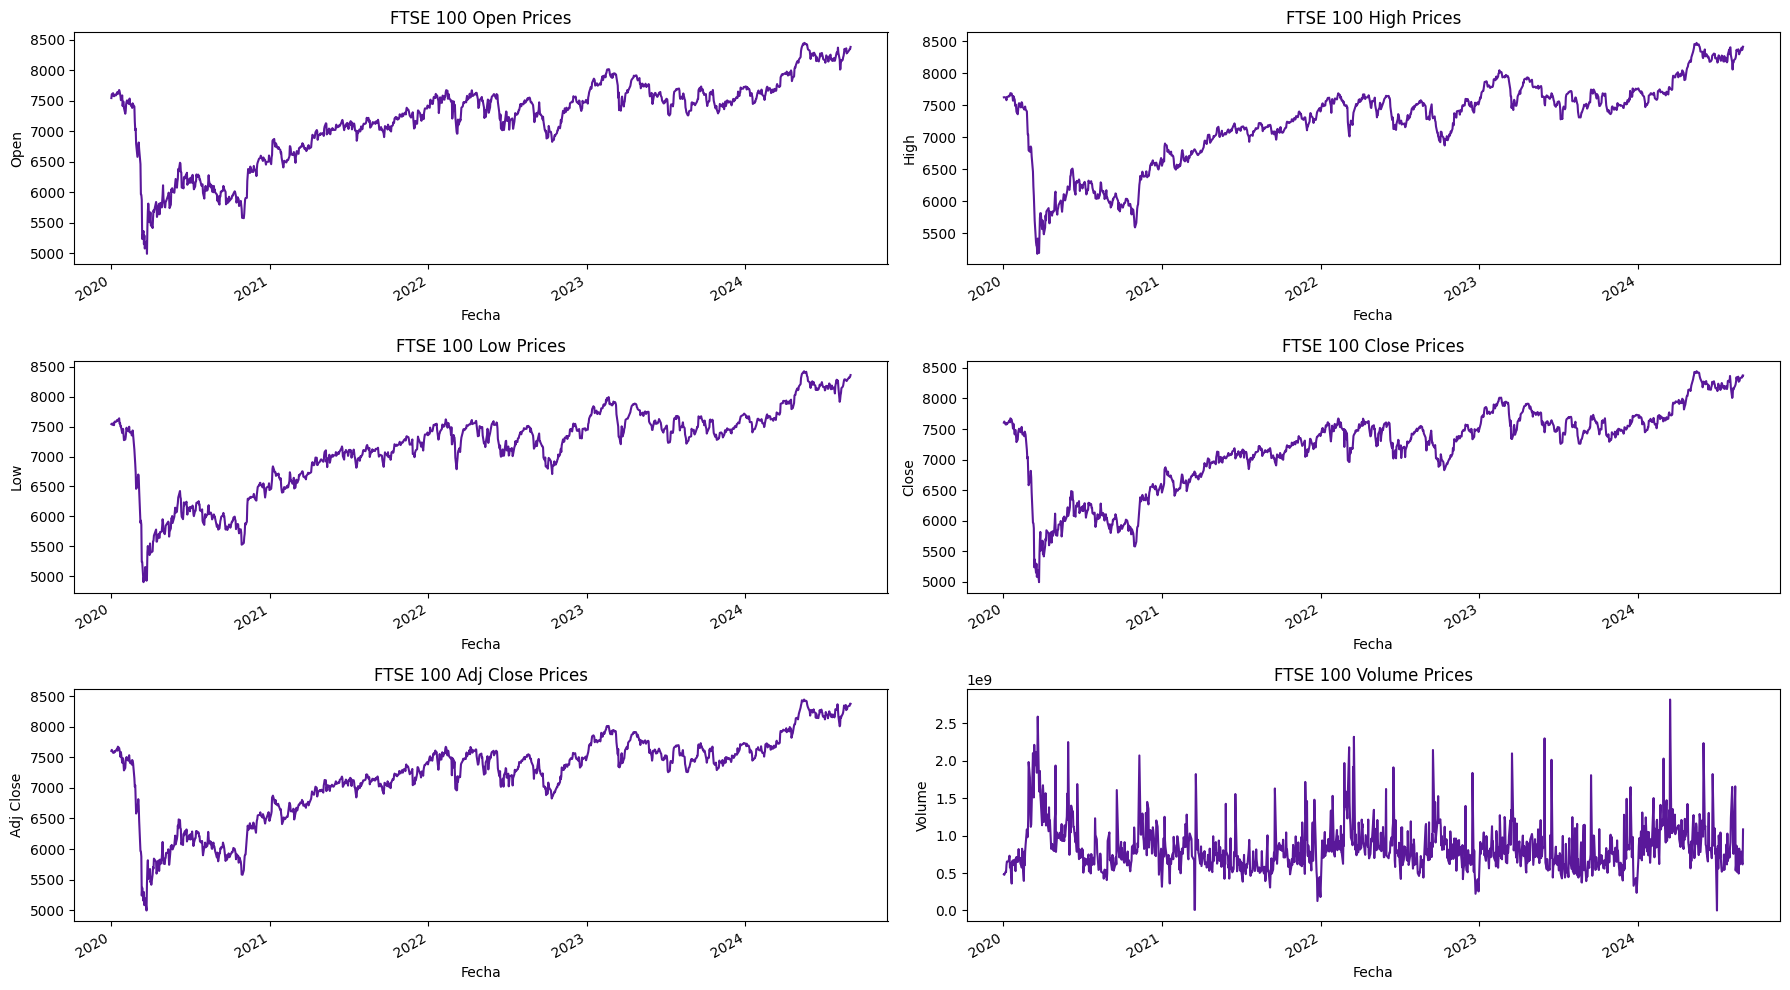

In [83]:
# Gráficos de Linea
vars = ['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']
color = '#5a189a'

fig, axes = plt.subplots(nrows=3, ncols=2, figsize=(18, 10))

for i, var in enumerate(vars):
    ax = axes[i // 2, i % 2]  
    ftse100[var].plot(ax=ax, color=color, title=f'FTSE 100 {var} Prices')
    ax.set_xlabel('Fecha')
    ax.set_ylabel(var)

plt.tight_layout()
plt.show()

Al analizar las series de tiempo de las diferentes variables del índice FTSE 100, se observa que tanto los precios de apertura (`Open`), precios altos (`High`), precios bajos (`Low`), precios de cierre (`Close`) y precios de cierre ajustados (`Adj Close`) muestran patrones de comportamiento similares a lo largo del tiempo. Todas estas variables reflejan una marcada caída alrededor de marzo de 2020, coincidiendo con el inicio de la pandemia de COVID-19 y la volatilidad en los mercados financieros globales. Posteriormente, se nota una tendencia general de recuperación y oscilación en las cotizaciones, lo que sugiere periodos de alta volatilidad seguidos de estabilización en los años subsiguientes. En contraste, la variable de volumen (`Volume`) muestra una mayor dispersión y variabilidad, sin un patrón estacional claro, lo que indica fluctuaciones en el interés de mercado o la liquidez del índice en diferentes periodos. Estas visualizaciones permiten entender mejor el comportamiento histórico del índice FTSE 100 y son fundamentales para identificar patrones, tendencias, y posibles puntos de inflexión en su análisis predictivo y de inversión futura.

# **Análisis de Datos Faltantes (NA)**

Para llevar a cabo un análisis exhaustivo de series de tiempo, es fundamental identificar y manejar adecuadamente los datos faltantes en el conjunto de datos. Los datos faltantes pueden surgir debido a diversas razones, como errores de registro o problemas de captura de datos, y pueden afectar significativamente el rendimiento y la precisión de los modelos predictivos. En esta sección, realizaremos una visualización de los datos faltantes para detectar posibles patrones o irregularidades en los datos históricos del índice FTSE 100. 

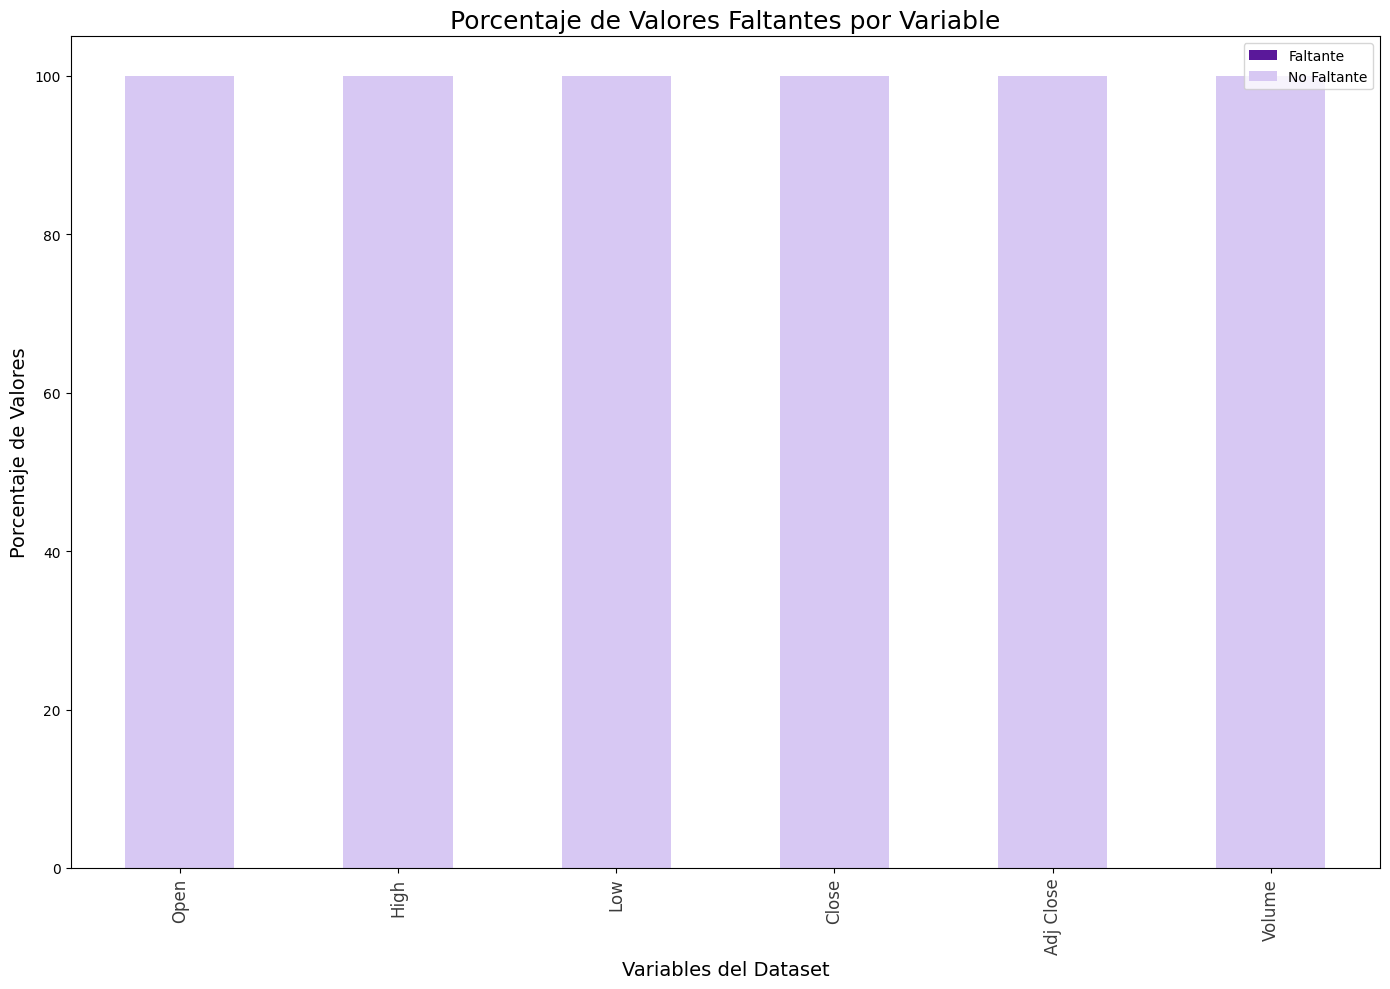

In [84]:
MissingPercentages = (ftse100.isnull().mean() * 100).sort_values(ascending=False)

MissingData = pd.DataFrame({'Faltante': MissingPercentages, 'No Faltante': 100 - MissingPercentages})

plt.figure(figsize=(14, 10))
MissingData.plot(kind='bar', stacked=True, color=['#5a189a', '#d7c8f3'], ax=plt.gca()) 

plt.title('Porcentaje de Valores Faltantes por Variable', fontsize=18)
plt.xlabel('Variables del Dataset', fontsize=14)
plt.ylabel('Porcentaje de Valores', fontsize=14)
plt.xticks(rotation=90, fontsize=12, color='#3B3B3B') 
plt.legend(['Faltante', 'No Faltante'], loc='upper right')

plt.tight_layout()
plt.show()


La gráfica muestra el porcentaje de valores faltantes por variable en el conjunto de datos del índice FTSE 100. Observamos que todas las variables (`Open`, `High`, `Low`, `Close`, `Adj Close` y `Volume`) tienen el 100% de sus valores presentes, lo que indica que no hay datos faltantes en ninguna de ellas. Esta ausencia de datos faltantes asegura que no se requerirán técnicas de imputación o eliminación de datos, lo cual es beneficioso para el análisis de series de tiempo, ya que permite trabajar directamente con los datos completos sin la necesidad de realizar preprocesamiento adicional para manejar valores faltantes.

# **Análisis de Correlación de las Variables**
En esta sección, se presenta la matriz de correlación entre las diferentes variables del índice FTSE 100 para entender las relaciones lineales que puedan existir entre ellas. La matriz de correlación permite identificar qué variables están estrechamente relacionadas, lo cual es esencial para simplificar el análisis y la modelación de series de tiempo. 

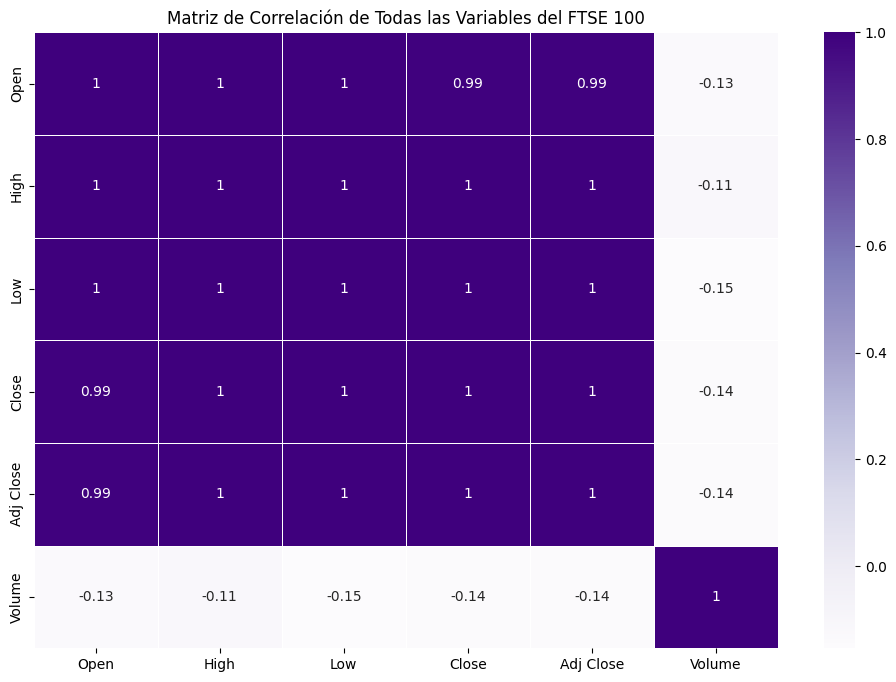

In [85]:
plt.figure(figsize=(12, 8))
sns.heatmap(ftse100.corr(), annot=True, cmap='Purples', linewidths=0.5)
plt.title('Matriz de Correlación de Todas las Variables del FTSE 100')
plt.show()

La matriz de correlación muestra una alta correlación positiva (cercana a 1) entre las variables `Open`, `High`, `Low`, `Close` y `Adj Close` en el índice FTSE 100, lo que indica que estas variables se mueven de manera similar y contienen información redundante. Por otro lado, la variable `Volume` muestra una correlación muy baja con las demás, lo que sugiere que captura información diferente sobre el mercado. Dado que `Adj Close` (cierre ajustado) refleja mejor el valor final ajustado por eventos corporativos como dividendos y divisiones de acciones, y mantiene la misma alta correlación que `Close`, es razonable quedarse con la variable `Adj Close` para un análisis de series de tiempo más representativo del comportamiento del índice sin redundancia innecesaria.

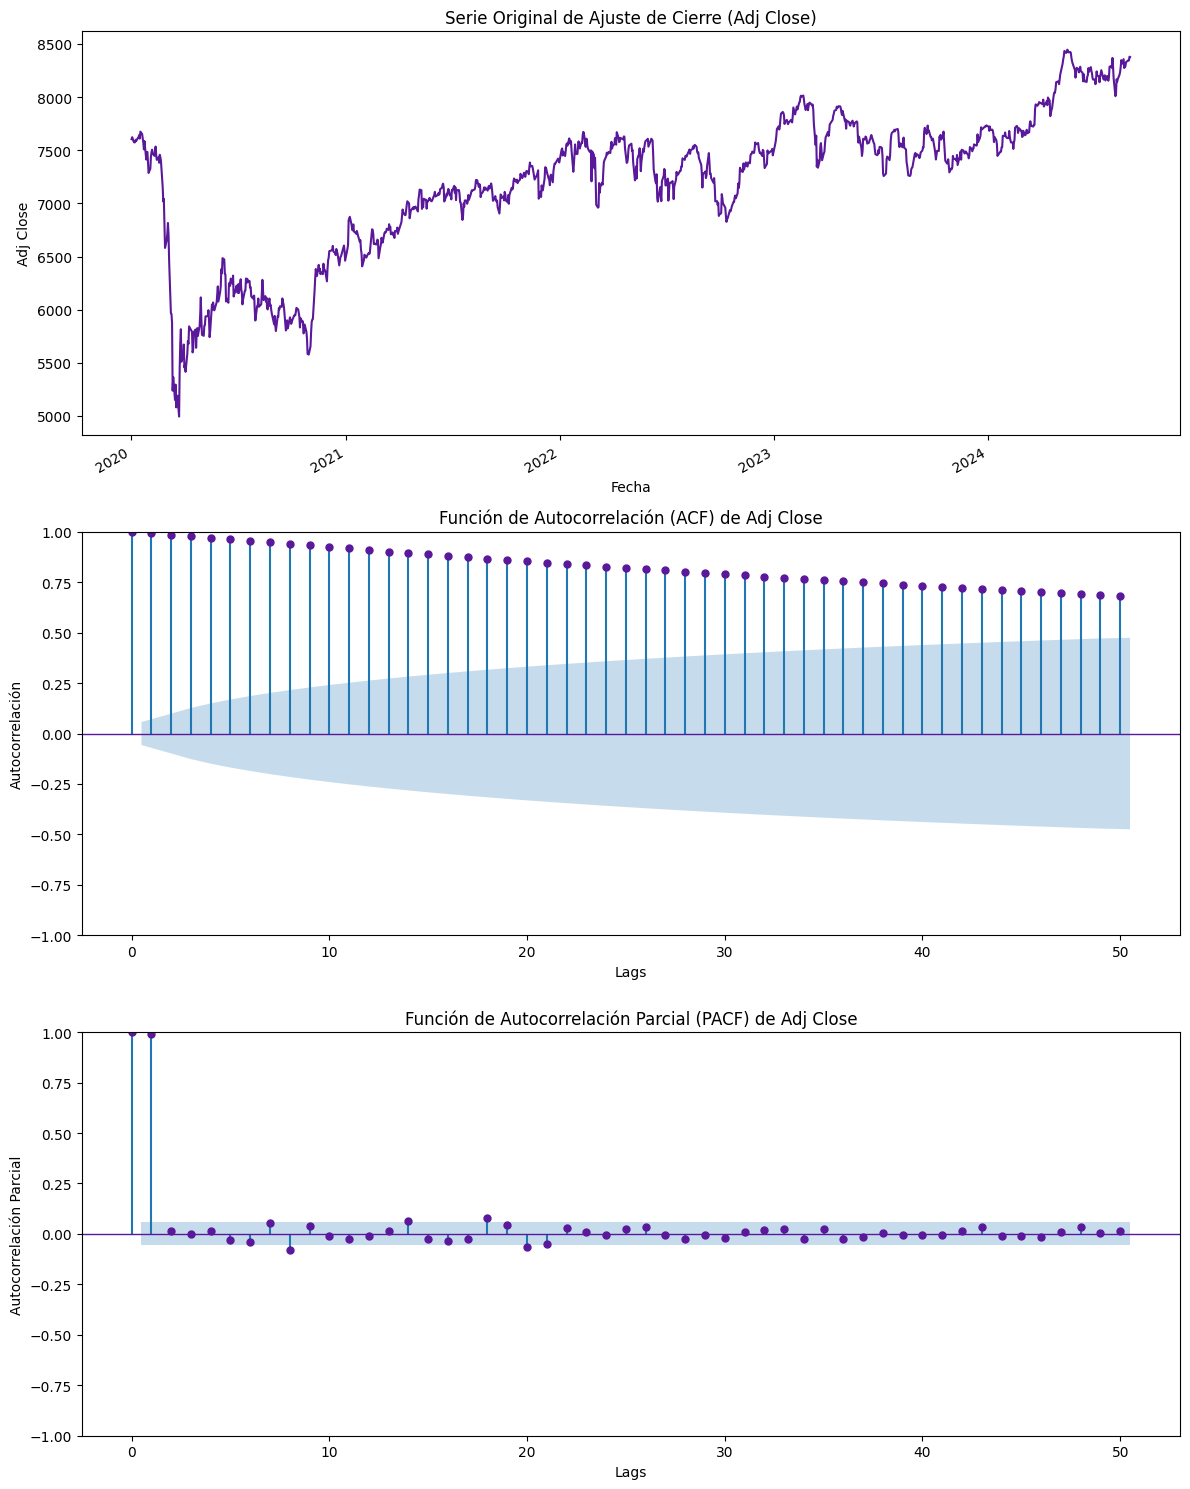

In [86]:
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# Parámetros de la figura
plt.rcParams.update({'figure.figsize': (15, 10)})
plt.rcParams['text.usetex'] = False  

# Parámetros de los gráficos de autocorrelación
nlag = 50

fig, axes = plt.subplots(3, 1, figsize=(12, 15))

# Gráfico de la serie de tiempo original de 'Adj Close'
ftse100['Adj Close'].plot(ax=axes[0], color='#5a189a')
axes[0].set_title('Serie Original de Ajuste de Cierre (Adj Close)')
axes[0].set_xlabel('Fecha')
axes[0].set_ylabel('Adj Close')

# Gráfico de Autocorrelación (ACF) para 'Adj Close'
plot_acf(ftse100['Adj Close'], lags=nlag, ax=axes[1], linewidth=1.0, color='#5a189a')
axes[1].set_title('Función de Autocorrelación (ACF) de Adj Close')
axes[1].set_xlabel('Lags')
axes[1].set_ylabel('Autocorrelación')

# Gráfico de Autocorrelación Parcial (PACF) para 'Adj Close'
plot_pacf(ftse100['Adj Close'], lags=nlag, ax=axes[2], linewidth=1.0, color='#5a189a', method='ywm')
axes[2].set_title('Función de Autocorrelación Parcial (PACF) de Adj Close')
axes[2].set_xlabel('Lags')
axes[2].set_ylabel('Autocorrelación Parcial')

plt.tight_layout()
plt.show()


El primer gráfico muestra la evolución temporal del precio de cierre ajustado desde 2020 hasta 2024. Se observa una tendencia general de recuperación y crecimiento, especialmente después de la caída significativa a principios de 2020, coincidiendo con el impacto inicial de la pandemia de COVID-19 en los mercados financieros. Posteriormente, el índice muestra oscilaciones de mediano plazo y un crecimiento sostenido, alcanzando niveles altos en 2024, lo que sugiere una recuperación económica y confianza del mercado.

El segundo gráfico, la Función de Autocorrelación (ACF) de la serie de tiempo, revela una alta autocorrelación positiva en los primeros lags, la cual disminuye gradualmente a medida que aumenta el número de lags. Este patrón de autocorrelación sugiere que el precio de cierre ajustado tiene una fuerte dependencia temporal, es decir, los valores pasados del índice tienen un efecto significativo en los valores futuros cercanos. La lenta disminución de la ACF es indicativa de una posible no estacionariedad en la serie de tiempo, lo que puede ser común en datos financieros donde las series muestran tendencias o ciclos prolongados.

El tercer gráfico, la Función de Autocorrelación Parcial (PACF), muestra que la autocorrelación disminuye abruptamente después del primer lag, lo que indica que el efecto de los precios pasados se controla en gran medida por los primeros rezagos. Este comportamiento es característico de un proceso AR (Autoregressive) de bajo orden, como AR(1) o AR(2), donde los efectos de autocorrelación más lejanos se vuelven insignificantes una vez que se considera la influencia del primer o segundo rezago. Este hallazgo sugiere que un modelo ARIMA de bajo orden podría ser adecuado para modelar esta serie de tiempo.

En conjunto, estos gráficos indican que la serie de tiempo del precio de cierre ajustado del FTSE 100 muestra patrones significativos de autocorrelación que pueden capturarse mediante modelos ARIMA. Sin embargo, la serie también sugiere no estacionariedad, lo que requerirá diferenciación para estabilizar la media y eliminar la tendencia antes de aplicar cualquier modelo predictivo. La información proporcionada por el ACF y el PACF es crucial para la selección del orden apropiado del modelo ARIMA que mejor describa y prediga el comportamiento futuro del índice.

# **Análisis de Estacionalidad**

El análisis de estacionalidad en series de tiempo es un componente esencial para comprender las fluctuaciones cíclicas que ocurren de manera regular en un periodo específico. En el contexto del índice FTSE 100, la estacionalidad puede reflejar patrones repetitivos influenciados por factores como ciclos económicos, eventos geopolíticos, tendencias del mercado o incluso efectos estacionales como los meses de cierre fiscal y el comportamiento de los inversores. En esta sección, exploraremos la presencia de estacionalidad en los datos del precio de cierre ajustado (Adj Close) del FTSE 100. Utilizaremos técnicas como la descomposición de la serie de tiempo y gráficos de autocorrelación (ACF y PACF) para identificar cualquier patrón estacional presente en diferentes frecuencias, como mensual, trimestral o anual. Un análisis adecuado de la estacionalidad no solo nos permitirá comprender mejor el comportamiento pasado del índice, sino también ajustar los modelos predictivos ARIMA para capturar efectivamente estos patrones, proporcionando una base sólida para las proyecciones futuras del mercado.

## **Prueba de Dickey-Fuller Aumentada (ADF)**

La prueba de Dickey-Fuller aumentada (ADF) es una prueba estadística que se utiliza para verificar si una serie de tiempo es estacionaria. La estacionariedad es una propiedad fundamental de las series de tiempo donde sus propiedades estadísticas (como la media, la varianza, y la autocorrelación) no cambian a lo largo del tiempo. Los modelos de series de tiempo como ARIMA requieren que los datos sean estacionarios para producir predicciones confiables.

### **Hipótesis de la Prueba ADF:**
- Hipótesis nula ($H_0$): La serie de tiempo no es estacionaria (tiene una raíz unitaria).
- Hipótesis alternativa ($H_1$): La serie de tiempo es estacionaria.

Si el valor p es menor que un nivel de significancia (0.05), se rechaza la hipótesis nula y se concluye que la serie de tiempo es estacionaria.


In [87]:
result = adfuller(ftse100['Adj Close'])

print('Estadístico ADF:', result[0])
print('Valor p:', result[1])
print('Número de rezagos utilizados:', result[2])
print('Número de observaciones utilizadas:', result[3])
print('Valores críticos:')
for key, value in result[4].items():
    print(f'   {key}: {value:.3f}')


Estadístico ADF: -1.4057488836865983
Valor p: 0.5795169492310881
Número de rezagos utilizados: 21
Número de observaciones utilizadas: 1154
Valores críticos:
   1%: -3.436
   5%: -2.864
   10%: -2.568


El resultado de la prueba de Dickey-Fuller Aumentada (ADF) para la serie de tiempo presenta un **estadístico ADF de -1.4057** y un **valor p de 0.5795**, lo cual es considerablemente mayor que los niveles de significancia habituales (1%, 5%, y 10%). Dado que el valor p es mayor que 0.05, no se puede rechazar la hipótesis nula de que la serie de tiempo tiene una raíz unitaria, lo que indica que la serie no es estacionaria en su forma actual. Además, los valores críticos de -3.436 (1%), -2.864 (5%), y -2.568 (10%) confirman que el estadístico ADF no supera estos umbrales, lo que refuerza la conclusión de que la serie de tiempo no es estacionaria. 

En consecuencia, para hacer que esta serie sea adecuada para modelos de series de tiempo que requieren estacionariedad, como el ARIMA, sería necesario aplicar transformaciones adicionales, como la diferenciación. Esto permitiría estabilizar la media de la serie y eliminar cualquier tendencia persistente antes de proceder con el análisis predictivo.

### **Estacionarización de la Serie de Tiempo**

La **diferenciación** es un método clave en el análisis de series de tiempo para eliminar la tendencia y convertir una serie no estacionaria en una serie estacionaria. La estacionariedad es esencial porque garantiza que las propiedades estadísticas de la serie, como la media y la varianza, sean constantes a lo largo del tiempo, lo que es un requisito para los modelos como ARIMA. La diferenciación se realiza restando cada valor de la serie con su valor anterior, lo que elimina tendencias lineales. Si una sola diferenciación no es suficiente, se pueden aplicar diferenciaciones adicionales.

En esta sección, aplicaremos la diferenciación a la serie `Adj Close` del índice FTSE 100 para eliminar la tendencia identificada en los análisis previos. Posteriormente, evaluaremos si la serie diferenciada es estacionaria mediante la **prueba de Dickey-Fuller Aumentada (ADF)**. Si la serie se vuelve estacionaria, estaremos listos para proceder con la construcción de modelos predictivos.

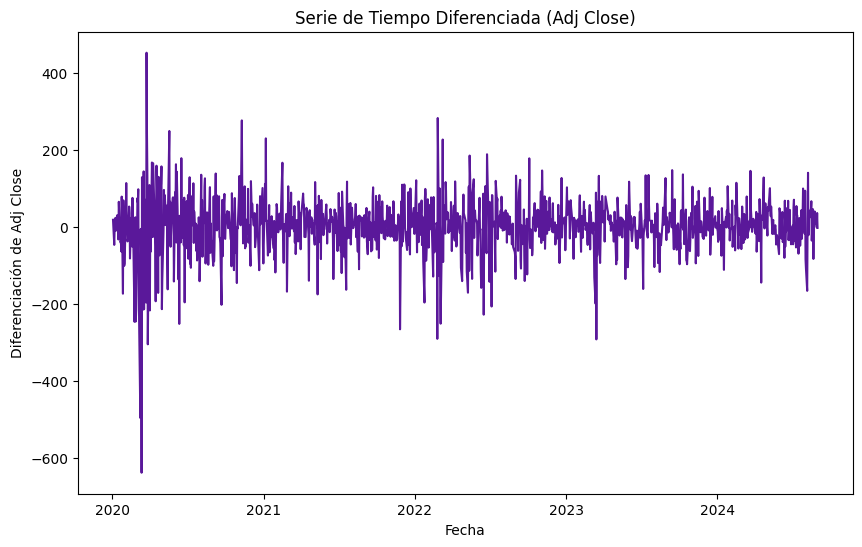

In [88]:
import matplotlib.pyplot as plt

# Aplicar diferenciación simple para estacionalizar la serie de tiempo
ftse100Dif = ftse100['Adj Close'].diff().dropna()

# Graficar la serie diferenciada
plt.figure(figsize=(10, 6))
plt.plot(ftse100Dif, color='#5a189a')
plt.title('Serie de Tiempo Diferenciada (Adj Close)')
plt.xlabel('Fecha')
plt.ylabel('Diferenciación de Adj Close')
plt.show()


#### **Comprobación de Estacionariedad**


In [89]:
from statsmodels.tsa.stattools import adfuller

# Prueba de Dickey-Fuller Aumentada (ADF) sobre la serie diferenciada
result_diff = adfuller(ftse100Dif)
print(f'Estadístico ADF: {result_diff[0]}')
print(f'Valor p: {result_diff[1]}')
print('Valores críticos:')
for key, value in result_diff[4].items():
    print(f'   {key}: {value:.3f}')

Estadístico ADF: -7.743837804636812
Valor p: 1.0446608933016453e-11
Valores críticos:
   1%: -3.436
   5%: -2.864
   10%: -2.568


El resultado de la prueba de Dickey-Fuller Aumentada (ADF) después de aplicar la diferenciación a la serie de tiempo muestra un **estadístico ADF de -7.7438** y un **valor p extremadamente bajo** de 1.04e-11. Este valor p es mucho menor que los niveles de significancia comunes (1%, 5%, y 10%), lo que indica que podemos **rechazar la hipótesis nula** de que la serie de tiempo tiene una raíz unitaria.

Además, los **valores críticos** de -3.436 (1%), -2.864 (5%) y -2.568 (10%) confirman que el estadístico ADF es mucho menor que cualquiera de estos umbrales, lo que refuerza la conclusión de que la serie diferenciada es **estacionaria**.

En resumen, después de aplicar la diferenciación, la serie de tiempo del precio de cierre ajustado (`Adj Close`) ahora cumple con las condiciones de estacionariedad, lo que la hace adecuada para su uso en modelos ARIMA u otros modelos de series de tiempo que requieren datos estacionarios para generar predicciones confiables.

## **Descomposición de la Serie de Tiempo**

Al descomponer la serie de tiempo en sus componentes de tendencia, estacionalidad y residuales, se puede obtener una comprensión más profunda de las dinámicas que afectan al índice a lo largo del tiempo, lo que permite mejorar la precisión de los modelos predictivos y tomar decisiones informadas.

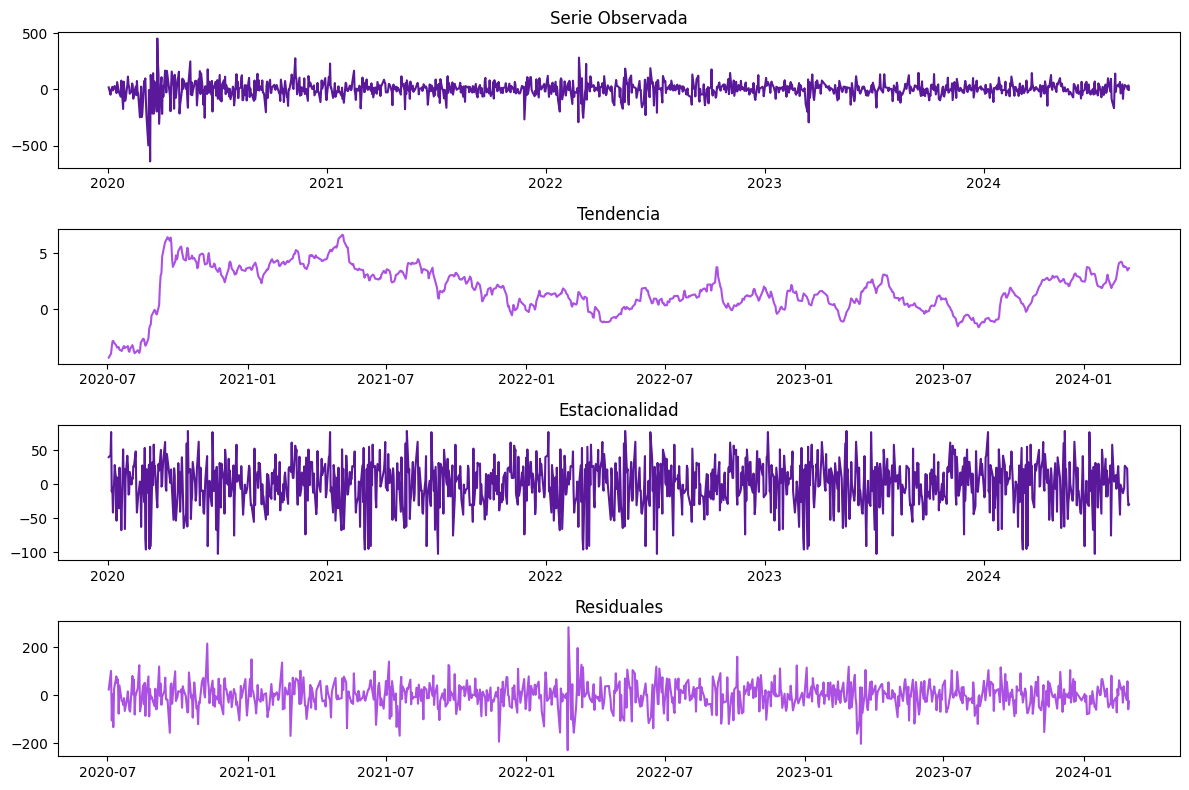

In [90]:
import matplotlib.pyplot as plt
from statsmodels.tsa.seasonal import seasonal_decompose

decomposition = seasonal_decompose(ftse100Dif, model='additive', period=252)

# Configurar el tamaño de la figura
plt.figure(figsize=(12, 8))

# Graficar la serie observada
plt.subplot(411)
plt.plot(decomposition.observed, color='#5a189a')
plt.title('Serie Observada')

# Graficar la tendencia
plt.subplot(412)
plt.plot(decomposition.trend, color='#ab51e3')
plt.title('Tendencia')

# Graficar la estacionalidad
plt.subplot(413)
plt.plot(decomposition.seasonal, color='#5a189a')
plt.title('Estacionalidad')

# Graficar los residuales
plt.subplot(414)
plt.plot(decomposition.resid, color='#ab51e3')
plt.title('Residuales')

# Ajustar el diseño de la cuadrícula
plt.tight_layout()
plt.show()


La gráfica muestra la descomposición de la serie de tiempo diferenciada (`Adj Close`) en cuatro componentes clave: la serie observada, tendencia, estacionalidad y residuales.

- **Serie Observada**: Muestra la serie diferenciada, que elimina la tendencia de largo plazo, y revela fluctuaciones a lo largo del tiempo con mayor intensidad a inicios de 2020, probablemente como reflejo de eventos significativos, como la caída del mercado durante la pandemia. Posteriormente, las fluctuaciones se estabilizan en amplitud.

- **Tendencia**: La tendencia diferenciada capta movimientos más sutiles en el comportamiento del mercado. Aunque se ha eliminado gran parte de la tendencia global, este componente muestra pequeñas fluctuaciones, lo que indica que aún persisten algunos movimientos de largo plazo en los datos, pero con menor magnitud.

- **Estacionalidad**: El componente estacional presenta oscilaciones regulares que parecen repetirse de manera cíclica, aunque no de forma muy pronunciada. Estas fluctuaciones reflejan patrones recurrentes en el mercado, posiblemente relacionados con factores cíclicos del comportamiento financiero.

- **Residuales**: Los residuales representan el ruido no explicado por la tendencia ni la estacionalidad. Aunque son relativamente aleatorios, aún se observan algunas oscilaciones fuertes en ciertos puntos, lo que podría sugerir la existencia de eventos externos o factores no modelados adecuadamente.

En general, la descomposición nos proporciona una visión clara de cómo se comportan los componentes individuales de la serie de tiempo diferenciada, lo que permite analizar más detalladamente los patrones estacionales y las fluctuaciones residuales, útiles para construir modelos predictivos más precisos.

### **Verificación de Estacionariedad en los Residuales del Modelo Aditivo**
En esta sección, se aplicará la prueba de Dickey-Fuller Aumentada (ADF) sobre los residuales obtenidos tras la descomposición aditiva de la serie de tiempo diferenciada del FTSE 100. El objetivo es verificar si los residuales resultantes son estacionarios, lo cual es un indicador de que los componentes de tendencia y estacionalidad han sido eliminados correctamente y que lo que resta es ruido blanco.



In [91]:
import numpy as np
from statsmodels.tsa import stattools

# Realizar la prueba de Dickey-Fuller Aumentada sobre los residuales del modelo aditivo
adf_result = stattools.adfuller(decomposition.resid[np.where(np.isfinite(decomposition.resid))[0]], autolag='AIC')

# Imprimir el valor p de la prueba ADF
print('P-valor de la prueba ADF sobre los residuales: ', adf_result[1])

# Interpretación del resultado
if adf_result[1] < 0.05:
    print("Los residuales son estacionarios.")
else:
    print("Los residuales no son estacionarios.")

P-valor de la prueba ADF sobre los residuales:  0.0
Los residuales son estacionarios.


El resultado de la prueba de Dickey-Fuller Aumentada (ADF) sobre los residuales de la serie diferenciada del FTSE 100 muestra un **p-valor de 0.0**, lo que indica que los residuales son **estacionarios**. Esto significa que el modelo ha logrado eliminar correctamente la tendencia y la estacionalidad de la serie, capturando los patrones predecibles y dejando solo ruido blanco o fluctuaciones aleatorias. Como consecuencia, podemos concluir que el modelo es adecuado y efectivo para representar los datos, lo que garantiza que las predicciones futuras basadas en este análisis serán más confiables y sin sesgos sistemáticos.